# Практическое занятие №6 и Лабораторная работа №4

Чадов Виктор Тимофеевич ББМО-01-22


In [1]:
# Выполним импорт необходимых библиотек

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

In [2]:
# Зададим нормализующие преобразования, загрузим набор данных (MNIST), разобьем данные на подвыборки

transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data:",len(test_loader))

100%|██████████| 9912422/9912422 [00:00<00:00, 37740690.93it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34699425.33it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 45298422.76it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1124322.99it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Training data: 50000 Validation data: 10000 Test data: 10000


In [3]:
# Настроим использование графического ускорителя (если возможно)
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

### Создание атак на модель НС

In [4]:
# Создадим класс НС на основе фреймворка torch
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

In [5]:
# Проверим работоспособность созданного класса НС
model = Net().to(device)

In [6]:
# Создадим оптимизатор, функцию потерь и трейнер сети
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [7]:
# Определим функцию обучения сети
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

In [8]:
# Обучим модель
loss, val_loss = fit(model, device, train_loader, val_loader, 10)

Fitting the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.24952410637191275 Val_Loss: 0.12004821480668401
Epoch: 2 Loss: 0.10400241406961643 Val_Loss: 0.08937057829162161
Epoch: 3 Loss: 0.08001298169125225 Val_Loss: 0.07487964439861787
Epoch: 4 Loss: 0.07031741707820172 Val_Loss: 0.0726085848842526
Epoch: 5 Loss: 0.0626050057411134 Val_Loss: 0.07915941863529125
Epoch: 6 Loss: 0.05902373343041917 Val_Loss: 0.07886546441267867
Epoch: 7 Loss: 0.05561302734572759 Val_Loss: 0.07421461555358806
Epoch: 8 Loss: 0.056511690853953495 Val_Loss: 0.07805111646014945
Epoch: 9 Loss: 0.04078879007479877 Val_Loss: 0.06336238800843882
Epoch: 10 Loss: 0.03795647511220834 Val_Loss: 0.059909901802669606


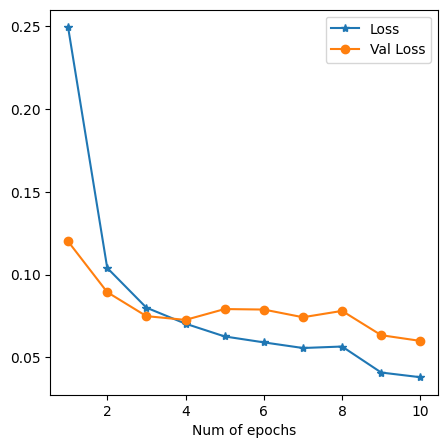

In [9]:
# Построим графики потерь при обучении и валидации в зависимости от эпохи
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

In [10]:
# Создадим функции атак FGSM, I-FGSM, MI-FGSM
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [11]:
# Создадим функцию проверки
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc, adv_examples


Epsilon: 0	Test Accuracy = 9766 / 10000 = 0.9766
Epsilon: 0.007	Test Accuracy = 9747 / 10000 = 0.9747
Epsilon: 0.01	Test Accuracy = 9725 / 10000 = 0.9725
Epsilon: 0.02	Test Accuracy = 9689 / 10000 = 0.9689
Epsilon: 0.03	Test Accuracy = 9648 / 10000 = 0.9648
Epsilon: 0.05	Test Accuracy = 9500 / 10000 = 0.95
Epsilon: 0.1	Test Accuracy = 8952 / 10000 = 0.8952
Epsilon: 0.2	Test Accuracy = 6983 / 10000 = 0.6983
Epsilon: 0.3	Test Accuracy = 4536 / 10000 = 0.4536


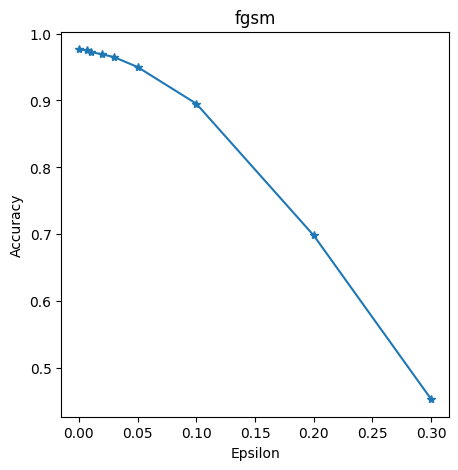

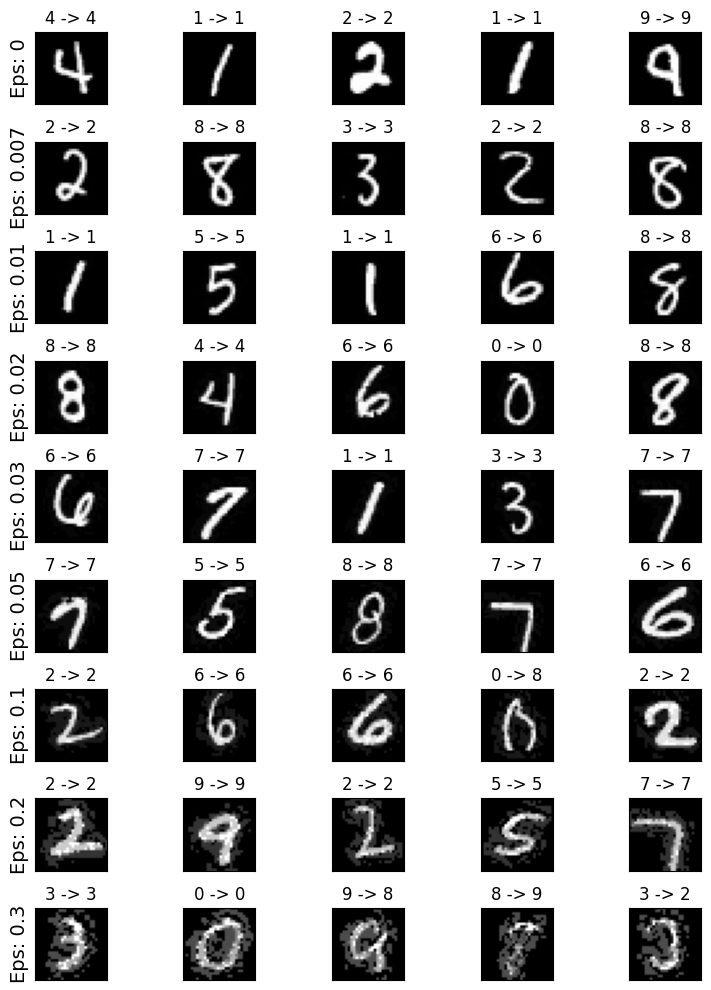

Epsilon: 0	Test Accuracy = 9776 / 10000 = 0.9776
Epsilon: 0.007	Test Accuracy = 9732 / 10000 = 0.9732
Epsilon: 0.01	Test Accuracy = 9740 / 10000 = 0.974
Epsilon: 0.02	Test Accuracy = 9696 / 10000 = 0.9696
Epsilon: 0.03	Test Accuracy = 9679 / 10000 = 0.9679
Epsilon: 0.05	Test Accuracy = 9555 / 10000 = 0.9555
Epsilon: 0.1	Test Accuracy = 9074 / 10000 = 0.9074
Epsilon: 0.2	Test Accuracy = 7471 / 10000 = 0.7471
Epsilon: 0.3	Test Accuracy = 5264 / 10000 = 0.5264


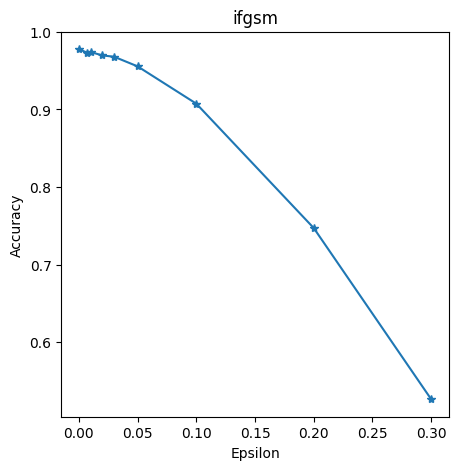

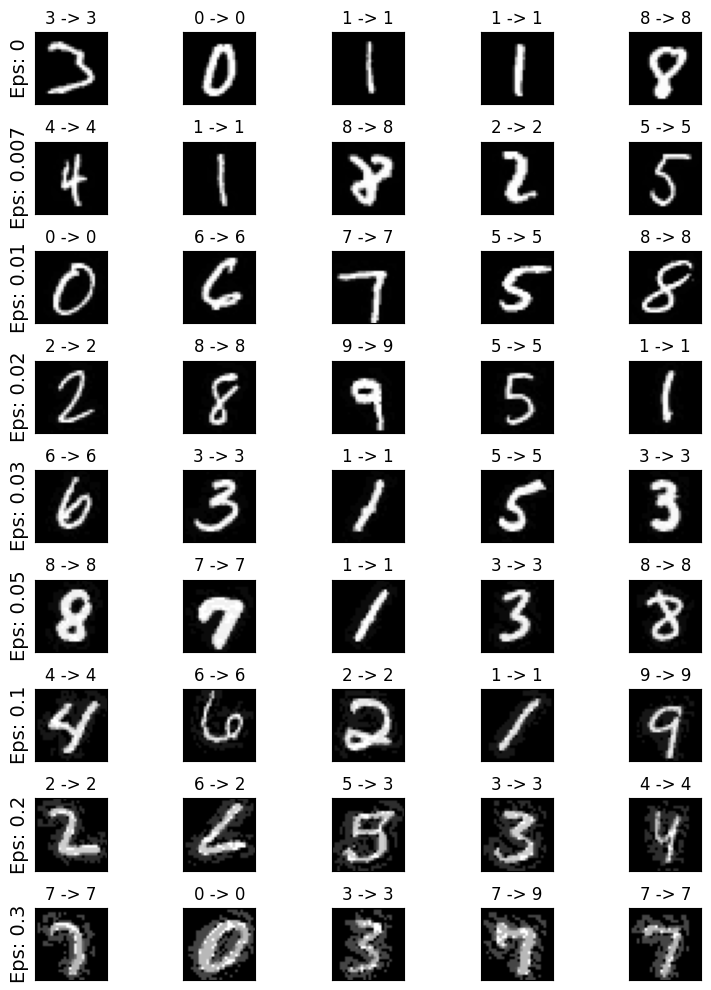

Epsilon: 0	Test Accuracy = 9778 / 10000 = 0.9778
Epsilon: 0.007	Test Accuracy = 9760 / 10000 = 0.976
Epsilon: 0.01	Test Accuracy = 9741 / 10000 = 0.9741
Epsilon: 0.02	Test Accuracy = 9706 / 10000 = 0.9706
Epsilon: 0.03	Test Accuracy = 9673 / 10000 = 0.9673
Epsilon: 0.05	Test Accuracy = 9552 / 10000 = 0.9552
Epsilon: 0.1	Test Accuracy = 9100 / 10000 = 0.91
Epsilon: 0.2	Test Accuracy = 7447 / 10000 = 0.7447
Epsilon: 0.3	Test Accuracy = 5288 / 10000 = 0.5288


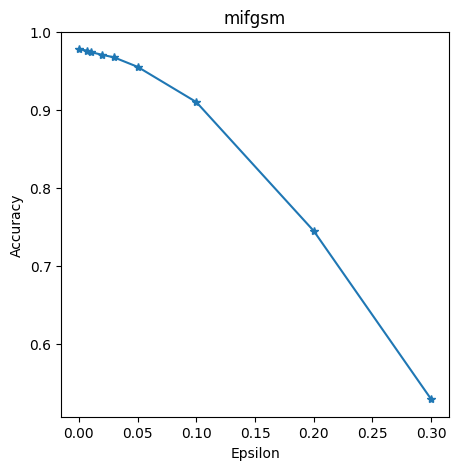

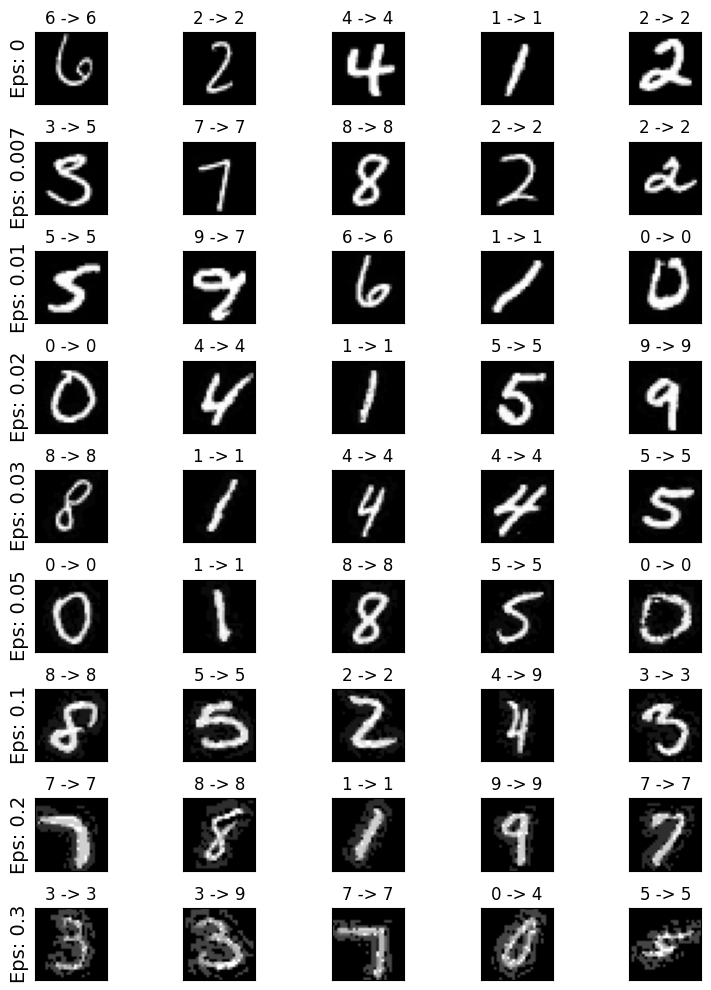

In [12]:
# Построим графики успешности атак (Accuracy/epsilon) и примеры выполненных атак в зависимости от степени возмущения epsilon
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
    acc, ex = test(model, device,test_loader,eps,attack)
    accuracies.append(acc)
    examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

### Защита от атак

In [13]:
# Создадим 2 класса НС
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [14]:
# Переопределим функцию обучения и тестирования
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
      else:
        val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

  def test(model,device,test_loader,epsilon,Temp,attack):
    correct=0
    adv_examples = []
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      output = F.log_softmax(output/Temp,dim=1)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
        continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data
      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
          adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
          adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
          if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc,adv_examples

In [20]:
# Создадим функцию защиты методом дистилляции
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):
  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)
  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)
  criterion = nn.NLLLoss()
  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  for data in train_loader:
    input, label = data[0].to(device),data[1].to(device)
    softlabel = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel
  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
      acc, ex = test(model,device,test_loader,eps,attack)
      accuracies.append(acc)
      examples.append(ex)
    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()
    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
      for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
          plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

Fitting the model...
Epoch: 1 Loss: 0.5212395416449636 Val_Loss: 8.332169745117426e-05
Epoch: 2 Loss: 0.3096809140265123 Val_Loss: 1.9176204595714808e-05
Epoch: 3 Loss: 0.22460909020119882 Val_Loss: 0.00012416129698976873
Epoch: 4 Loss: 0.16846141684400126 Val_Loss: 1.2067891366314143e-07
Epoch: 5 Loss: 0.14119364851545071 Val_Loss: 0.0003323394298553467
Epoch: 6 Loss: 0.11766547573028574 Val_Loss: 3.3418718463508413e-06
Epoch: 7 Loss: 0.10488218381628883 Val_Loss: 1.9453065760188793e-08
Epoch: 8 Loss: 0.1007843225015228 Val_Loss: 2.1551304939748662e-07
Epoch: 9 Loss: 0.09000281498103405 Val_Loss: 3.6529124598018825e-06
Epoch: 10 Loss: 0.08948985433637965 Val_Loss: 4.057854221900925e-06


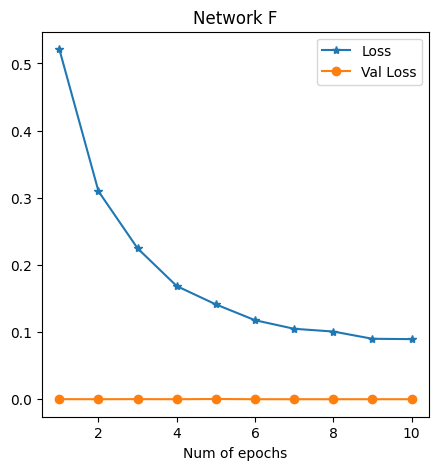

Fitting the model...
Epoch: 1 Loss: 0.656994630778291 Val_Loss: 5.873731672763825e-05
Epoch: 2 Loss: 0.44042982941789627 Val_Loss: 0.0003109028577804565
Epoch: 3 Loss: 0.3796982913506828 Val_Loss: 2.1117657306604088e-07
Epoch: 4 Loss: 0.3293539399564022 Val_Loss: 0.00015530742518603803
Epoch: 5 Loss: 0.2863226317807831 Val_Loss: 3.918354585766792e-06
Epoch: 6 Loss: 0.24653427825215093 Val_Loss: 5.067832265049219e-05
Epoch: 7 Loss: 0.21754332489682862 Val_Loss: 1.8833227222785354e-05
Epoch: 8 Loss: 0.18981069880445836 Val_Loss: 7.940889772726223e-08
Epoch: 9 Loss: 0.18495245350062442 Val_Loss: 3.9697694589904133e-07
Epoch: 10 Loss: 0.18157111856095812 Val_Loss: 7.286503911018371e-06


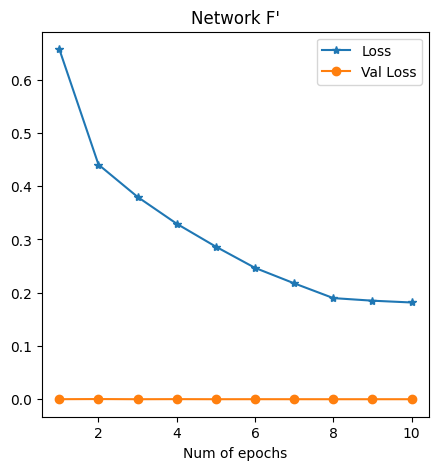

Epsilon: 0	Test Accuracy = 9225 / 10000 = 0.9225
Epsilon: 0.007	Test Accuracy = 9186 / 10000 = 0.9186
Epsilon: 0.01	Test Accuracy = 9142 / 10000 = 0.9142
Epsilon: 0.02	Test Accuracy = 9115 / 10000 = 0.9115
Epsilon: 0.03	Test Accuracy = 8973 / 10000 = 0.8973
Epsilon: 0.05	Test Accuracy = 8741 / 10000 = 0.8741
Epsilon: 0.1	Test Accuracy = 7838 / 10000 = 0.7838
Epsilon: 0.2	Test Accuracy = 4249 / 10000 = 0.4249
Epsilon: 0.3	Test Accuracy = 1316 / 10000 = 0.1316


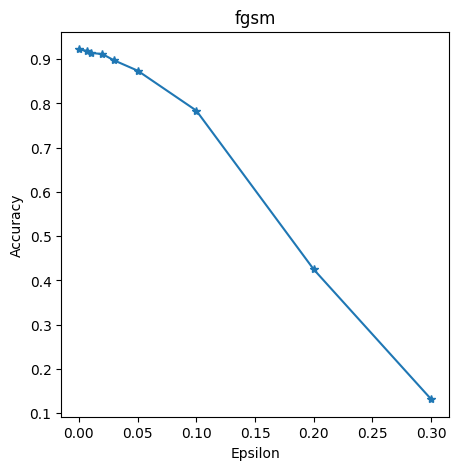

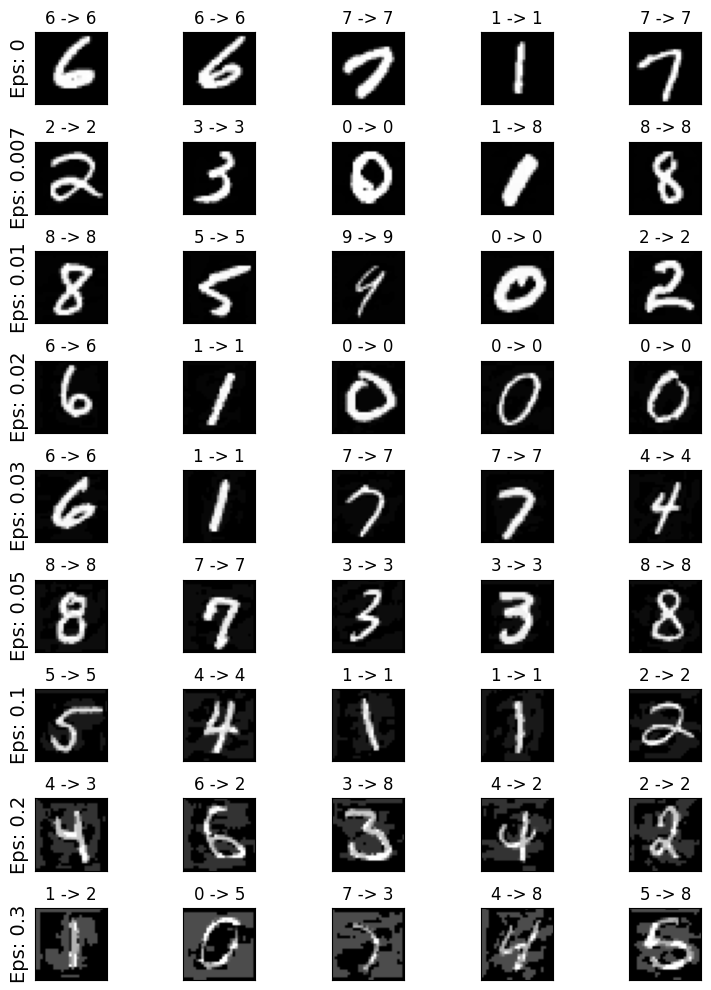

Epsilon: 0	Test Accuracy = 9229 / 10000 = 0.9229
Epsilon: 0.007	Test Accuracy = 9194 / 10000 = 0.9194
Epsilon: 0.01	Test Accuracy = 9216 / 10000 = 0.9216
Epsilon: 0.02	Test Accuracy = 9071 / 10000 = 0.9071
Epsilon: 0.03	Test Accuracy = 9038 / 10000 = 0.9038
Epsilon: 0.05	Test Accuracy = 8803 / 10000 = 0.8803
Epsilon: 0.1	Test Accuracy = 8054 / 10000 = 0.8054
Epsilon: 0.2	Test Accuracy = 5123 / 10000 = 0.5123
Epsilon: 0.3	Test Accuracy = 1855 / 10000 = 0.1855


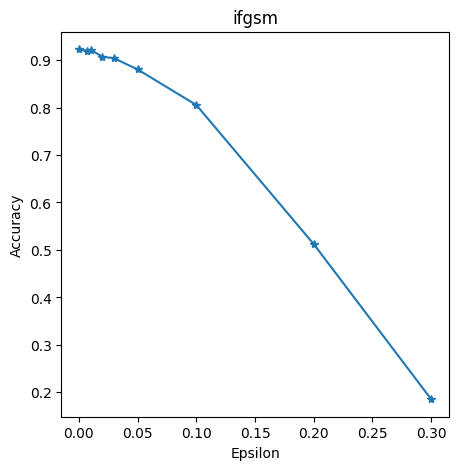

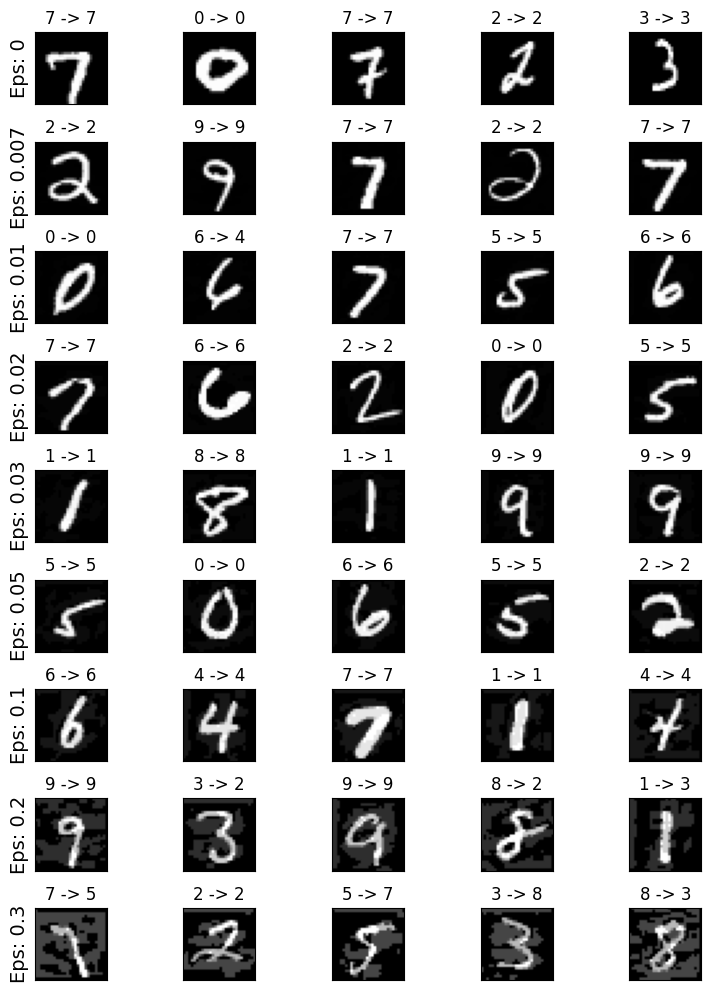

Epsilon: 0	Test Accuracy = 9205 / 10000 = 0.9205
Epsilon: 0.007	Test Accuracy = 9169 / 10000 = 0.9169
Epsilon: 0.01	Test Accuracy = 9159 / 10000 = 0.9159
Epsilon: 0.02	Test Accuracy = 9147 / 10000 = 0.9147
Epsilon: 0.03	Test Accuracy = 9016 / 10000 = 0.9016
Epsilon: 0.05	Test Accuracy = 8824 / 10000 = 0.8824
Epsilon: 0.1	Test Accuracy = 8042 / 10000 = 0.8042
Epsilon: 0.2	Test Accuracy = 5156 / 10000 = 0.5156
Epsilon: 0.3	Test Accuracy = 1959 / 10000 = 0.1959


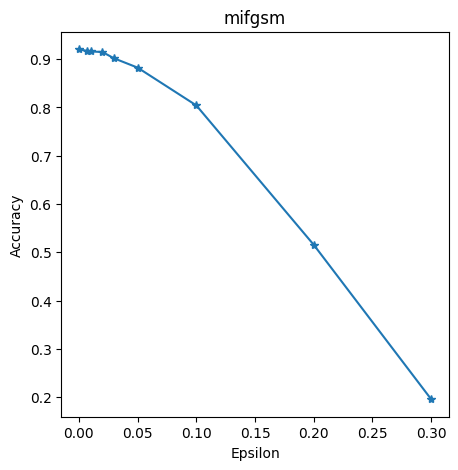

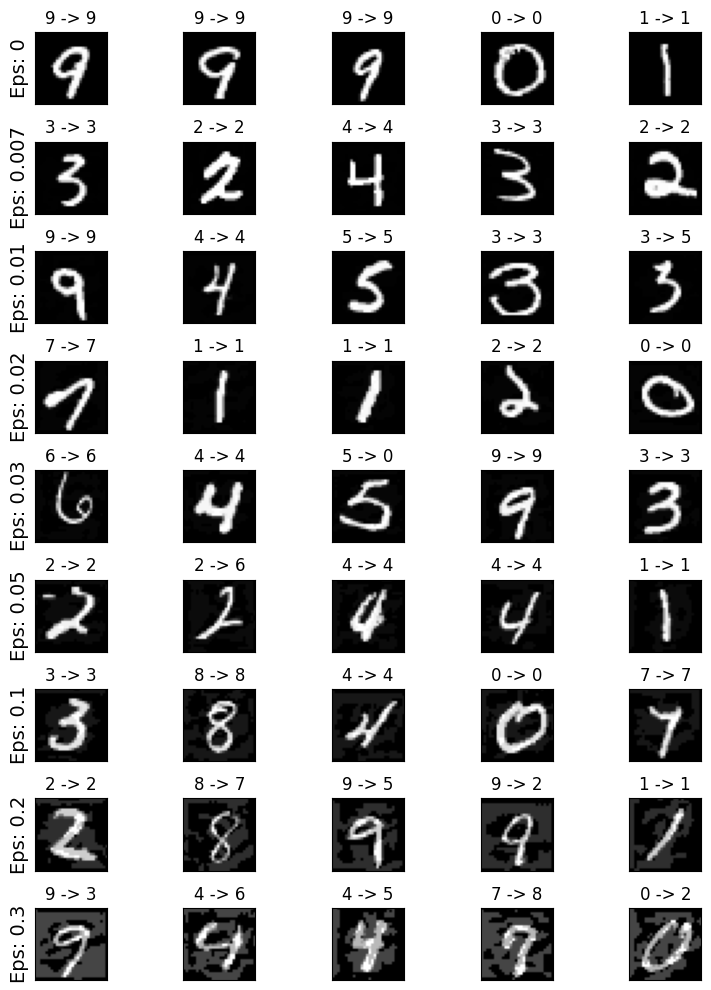

In [22]:
# Получаем результаты оценки защищенных сетей
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)


### Выводы:
В данной работе мы успешно создали модели и загрузили данные, обучили их, протестировали и применили защитную дистилляцию.
В целом, защитная дистилляция является полезным методом для уменьшения сложности модели нейронной сети и увеличения скорости обучения и выполнения, но ее эффективность может зависеть от многих факторов, включая сложность исходной модели, качество обучения и размер обучающего набора данных.